In [7]:
!pip install pyyaml pydantic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.3/409.3 kB 592.0 kB/s eta 0:00:000:00:01m eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 417.3 kB/s eta 0:00:00m eta 0:00:010:00:01

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [8]:
import dgl
import numpy as np
import networkx as nx

import torch
from torch import nn

In [9]:
%load_ext autoreload
%autoreload 2

### Creating a dgl graph from connectivity matrix

In [10]:
TEST_PATH = "../data/deap_filtered/s01_plv.npy"
connectivity_matrix = np.load(TEST_PATH)
connectivity_matrix.shape

(32, 32, 5)

In [11]:
connectivity_matrix = connectivity_matrix[:, :, -1]
connectivity_matrix

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.57803585, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.33041863, 0.56471143, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.28629317, 0.28253806, 0.27283744, ..., 0.        , 0.        ,
        0.        ],
       [0.34106162, 0.56037416, 0.60070708, ..., 0.27732514, 0.        ,
        0.        ],
       [0.37746005, 0.45468193, 0.43395707, ..., 0.25628626, 0.71649264,
        0.        ]])

In [12]:
threshold = 0.3
connectivity_matrix[connectivity_matrix < threshold] = 0 # remove weak connections
connectivity_matrix += np.rot90(np.fliplr(connectivity_matrix)) # make the matrix symmetric

In [13]:
nx_graph = nx.from_numpy_array(connectivity_matrix)
nx_graph = nx_graph.to_directed()


In [14]:
nx_graph.number_of_edges()

426

In [15]:
dgl_graph = dgl.from_networkx(nx_graph, edge_attrs=['weight'])
dgl_graph

Graph(num_nodes=32, num_edges=426,
      ndata_schemes={}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float32)})

### Centrality encoding

In [16]:
n_nodes = dgl_graph.number_of_nodes()
dim_feedforward = 64

centrality_encoding = nn.Embedding(n_nodes, dim_feedforward)

In [17]:
dgl_graph.in_degrees().shape

torch.Size([32])

In [18]:
centrality = centrality_encoding(dgl_graph.in_degrees())
centrality.shape # (n_nodes, dim_feedforward)

torch.Size([32, 64])

### Spatial encoding

In [19]:
n_heads = 4
spatial_encoding = nn.Embedding(n_nodes, n_heads)

In [20]:
spd = dgl.shortest_dist(dgl_graph)
spd.shape

torch.Size([32, 32])

In [21]:
spatial = spatial_encoding(spd)
spatial.shape # (n_nodes, n_nodes, n_heads)

torch.Size([32, 32, 4])

### Edge encoding

In [22]:
spd, paths = dgl.shortest_dist(dgl_graph, return_paths=True)
paths[0, 2] # Each path is a vector that consists of edge IDs with paddings of -1 at the end. (via documentation)

tensor([ 1, -1, -1])

In [23]:
path = paths[0, 2]
path = path[path >= 0]
path

tensor([1])

In [24]:
edge_encoder = nn.Embedding(n_nodes ** 2, n_heads)
edge_features = dgl_graph.edata['weight']

In [25]:
i, j = 12, 24

_, path = dgl.shortest_dist(dgl_graph, i, return_paths=True)
# path is a sequence of nodes, len(path) == max_path 
# -1 is a padding value
path = path[j]
path = path[path >= 0] # remove padding
edge_embeds = edge_encoder(path) # (n_spd, n_heads)
spd_features = edge_features[path] # (n_spd)
result = torch.mean(edge_embeds * spd_features.unsqueeze(-1), dim=0)
result, result.shape

(tensor([-0.5587, -0.2196,  0.0016,  0.3718], grad_fn=<MeanBackward1>),
 torch.Size([4]))

### Parsing the data

In [26]:
import torch
import os
import pickle
import numpy as np
from tqdm import tqdm

class EEGDataset(torch.utils.data.Dataset):
    def __init__(self, 
                 data_path: str = "../data/deap_filtered",
                 duration : float = 3.0,
                 method : str = "plv",
                 participants_range : tuple = (0, 32),
                 n_trials=40):
        self.n_trials = n_trials

        participants = [file[:-4] for file in os.listdir(data_path) if file.endswith('.dat')][participants_range[0]:participants_range[1]]
        self.paths = []
        self.labels = []

        for participant in tqdm(participants):
            # labels
            labels_for_participant = pickle.load(open(f"{data_path}/{participant}.dat", "rb"), encoding="latin1")["labels"]
            self.labels.append(labels_for_participant)

            # data
            duration_str = str(duration)
            prefix = f"{data_path}/{participant}_{method}_{duration_str}_trial_" # inside the collate_fn we add postfixes for all trials
            self.paths.append(prefix)


    def __getitem__(self, idx):
        # each dataset item is one participant
        # for each participant, we have a list of 40 trials 
        # each trial is a tuple of (connectivity_matrix, label)
        # connectivity_matrix is a 3D numpy array of shape (n_channels, n_channels, n_bands)
        # label is a scalar
        return {
            "path_prefix": self.paths[idx],
            "labels": self.labels[idx],
            "n_trials": self.n_trials
        }


    def __len__(self):
        return len(self.paths)

In [27]:
dataset = EEGDataset()

  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:04<00:00,  6.50it/s]


In [43]:
def collate_fn(participant): # participant is actually the whole batch, as there are 40 trials for each participant
    matrices = []
    labels = []

    if isinstance(participant, list):
        participant = participant[0]
    for trial in range(participant["n_trials"]):
        path = participant["path_prefix"] + str(trial) + ".npy"
        connectivity_matrix = torch.from_numpy(np.load(path)) # matrices for all bands
        matrices.extend(torch.split(connectivity_matrix, 1, dim=-1)) # split along the last axis
        labels.extend([participant["labels"][trial] for b in range(connectivity_matrix.shape[-1])]) # replicate the label for each band

    return {
        "matrices": torch.stack(matrices, dim=0).squeeze(-1),
        "labels": torch.as_tensor(labels) # n_trials * b_bands,  (valence, arousal, dominance, liking)
    }

In [44]:
collate_fn(dataset[0])["labels"].shape #
# 160 = n_trials * n_bands
# 32 = n_channels
# shape = n_trials * n_bands, 4

torch.Size([160, 4])

In [51]:
# create datasets
train_dataset = EEGDataset(participants_range=(1, 30))
val_dataset = EEGDataset(participants_range=(30, 33))

# create dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)


100%|██████████| 2/2 [00:00<00:00,  6.29it/s]


In [52]:
def process_batch(model, 
                  batch, 
                  optimizer,
                  criterion,
                  device,
                  is_train=True):
    """
    :param model: torch.nn.Module, current model
    :param batch: dict, a batch that is being processed
    """
    for tensor_for_gpu in batch.keys():
        batch[tensor_for_gpu] = batch[tensor_for_gpu].to(device)
    predictions, attention = model(batch)
    if type(predictions) is dict:
        batch.update(predictions)
    else:
        batch["predictions"] = predictions
        batch["attention"] = attention

    optimizer.zero_grad()
    loss = criterion(batch["predictions"], batch["labels"].float())
    if is_train:
        loss.backward()
        optimizer.step()
    batch["loss"] = loss

    return batch



def train_epoch(epoch, model, optimizer, criterion, train_loader, device, log_step=5):
    """
    Training logic for an epoch

    :param epoch: Integer, current training epoch.
    :return: A log that contains average loss and metric in this epoch.
    """
    model.train()
    # DEBUG
    # torch.autograd.set_detect_anomaly(True)
    for batch_idx, batch in enumerate(
            tqdm(train_loader, desc="train")):
        try:
            batch = process_batch(model,
                                batch,
                                optimizer,
                                criterion,
                                device
                                )
        except RuntimeError as e:
            if "out of memory" in str(e):
                print("OOM on batch. Skipping batch.")
                for p in model.parameters():
                    if p.grad is not None:
                        del p.grad  # free some memory
                torch.cuda.empty_cache()
                continue
            else:
                raise e
        print( # plot loss after every participant
            "Train Epoch: {} {} Loss: {:.6f}".format(
            epoch, batch_idx, batch["loss"].item()
        ))

def evaluate_epoch(model, criterion, optimizer, val_loader, device):
    """
    Evaluate after training an epoch

    :return: A log that contains information about the evaluation
    """
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_idx, batch in enumerate(
                tqdm(val_loader, desc="val")):
            batch = process_batch(model,
                                batch,
                                optimizer,
                                criterion,
                                device,
                                is_train=False
                                )
            val_loss += batch["loss"].item()
    val_loss /= len(val_loader)
    print("Val set: Average loss: {:.4f}".format(val_loss))
    return {
        "val_loss": val_loss
    }

0

In [46]:
# installing cuda with dgl
# !pip uninstall -y dgl
# !pip install  dgl -f https://data.dgl.ai/wheels/torch-2.1/cu121/repo.html

In [36]:
%%time

one_batch_dataset = EEGDataset(participants_range=(1, 2))
train_loader = torch.utils.data.DataLoader(one_batch_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from src.model import GraphormerModel

model = GraphormerModel(
    n_nodes = 32,
    n_layers = 1,
    n_heads = 4,
    embed_dim = 8,
    dim_feedforward=16,
    device=device
)


model.to(device)
for batch in train_loader:
    predictions, attention = model(batch)
    print(predictions.shape)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.25it/s]


torch.Size([160, 4])
CPU times: user 3min 51s, sys: 1.84 s, total: 3min 53s
Wall time: 3min 54s


In [53]:
# training the model

n_epochs = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from src.model import GraphormerModel

import torch.optim as optim
from torch.nn import MSELoss

model = GraphormerModel(
    n_nodes = 32,
    n_layers = 4,
    n_heads = 4,
    embed_dim = 64,
    dim_feedforward=128,
    device=device
)


optimizer = optim.Adam(model.parameters(), lr=3e-4)
criterion = MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

for epoch in range(n_epochs):
    train_epoch(epoch, model, optimizer, criterion, train_loader, device)
    evaluate_epoch(model, criterion, optimizer, val_loader, device)

cuda


train:   0%|          | 0/29 [00:00<?, ?it/s]

train:   3%|▎         | 1/29 [04:13<1:58:10, 253.23s/it]

Train Epoch: 0 0 Loss: 23.855812


train:   7%|▋         | 2/29 [08:36<1:56:40, 259.27s/it]

Train Epoch: 0 1 Loss: 28.749884


train:  10%|█         | 3/29 [13:03<1:53:47, 262.59s/it]

Train Epoch: 0 2 Loss: 20.631453


train:  14%|█▍        | 4/29 [17:25<1:49:20, 262.41s/it]

Train Epoch: 0 3 Loss: 35.999966


train:  17%|█▋        | 5/29 [21:46<1:44:47, 261.96s/it]

Train Epoch: 0 4 Loss: 23.650076


train:  21%|██        | 6/29 [26:08<1:40:22, 261.83s/it]

Train Epoch: 0 5 Loss: 14.311424


train:  24%|██▍       | 7/29 [30:27<1:35:40, 260.94s/it]

Train Epoch: 0 6 Loss: 15.396483


train:  28%|██▊       | 8/29 [34:52<1:31:48, 262.31s/it]

Train Epoch: 0 7 Loss: 10.688985


train:  31%|███       | 9/29 [39:16<1:27:39, 262.95s/it]

Train Epoch: 0 8 Loss: 12.638784


train:  34%|███▍      | 10/29 [43:35<1:22:53, 261.77s/it]

Train Epoch: 0 9 Loss: 10.049247


train:  38%|███▊      | 11/29 [47:59<1:18:41, 262.29s/it]

Train Epoch: 0 10 Loss: 8.528439


train:  41%|████▏     | 12/29 [52:20<1:14:14, 262.03s/it]

Train Epoch: 0 11 Loss: 5.193382


train:  45%|████▍     | 13/29 [56:40<1:09:39, 261.20s/it]

Train Epoch: 0 12 Loss: 9.518985


train:  48%|████▊     | 14/29 [1:00:58<1:05:04, 260.31s/it]

Train Epoch: 0 13 Loss: 3.007769


train:  52%|█████▏    | 15/29 [1:05:22<1:01:01, 261.51s/it]

Train Epoch: 0 14 Loss: 4.540798


train:  55%|█████▌    | 16/29 [1:09:48<56:55, 262.72s/it]  

Train Epoch: 0 15 Loss: 7.597609


train:  59%|█████▊    | 17/29 [1:14:15<52:47, 263.96s/it]

Train Epoch: 0 16 Loss: 4.916087


train:  62%|██████▏   | 18/29 [1:18:36<48:14, 263.11s/it]

Train Epoch: 0 17 Loss: 6.013725


train:  66%|██████▌   | 19/29 [1:23:01<43:56, 263.61s/it]

Train Epoch: 0 18 Loss: 2.649888


train:  69%|██████▉   | 20/29 [1:27:18<39:16, 261.82s/it]

Train Epoch: 0 19 Loss: 6.314189


train:  72%|███████▏  | 21/29 [1:31:42<34:58, 262.29s/it]

Train Epoch: 0 20 Loss: 3.341959


train:  76%|███████▌  | 22/29 [1:36:02<30:31, 261.68s/it]

Train Epoch: 0 21 Loss: 1.512393


train:  79%|███████▉  | 23/29 [1:40:20<26:03, 260.66s/it]

Train Epoch: 0 22 Loss: 3.647070


train:  83%|████████▎ | 24/29 [1:44:43<21:46, 261.32s/it]

Train Epoch: 0 23 Loss: 8.935773


train:  86%|████████▌ | 25/29 [1:49:03<17:24, 261.06s/it]

Train Epoch: 0 24 Loss: 5.455022


train:  90%|████████▉ | 26/29 [1:53:25<13:03, 261.24s/it]

Train Epoch: 0 25 Loss: 4.404083


train:  93%|█████████▎| 27/29 [1:57:50<08:44, 262.25s/it]

Train Epoch: 0 26 Loss: 3.764706


train:  97%|█████████▋| 28/29 [2:02:10<04:21, 261.72s/it]

Train Epoch: 0 27 Loss: 6.434838


train: 100%|██████████| 29/29 [2:06:30<00:00, 261.74s/it]

Train Epoch: 0 28 Loss: 3.489348



val: 100%|██████████| 2/2 [08:10<00:00, 245.02s/it]

Val set: Average loss: 3.8923


In [54]:
# saving the model
torch.save(model.state_dict(), "graphormer.pt")

In [56]:
for batch in train_loader:
    predictions, attention = model(batch)
    break

In [58]:
attention.shape

torch.Size([160, 4, 1, 4, 32, 32])

In [60]:
attention = torch.squeeze(attention)
attention.shape # (n_trials * n_bands, n_layers, n_heads, n_nodes, n_nodes)

torch.Size([160, 4, 4, 32, 32])

In [61]:
attention_grouped = torch.mean(attention, dim=1)
attention_grouped.shape

torch.Size([160, 4, 32, 32])

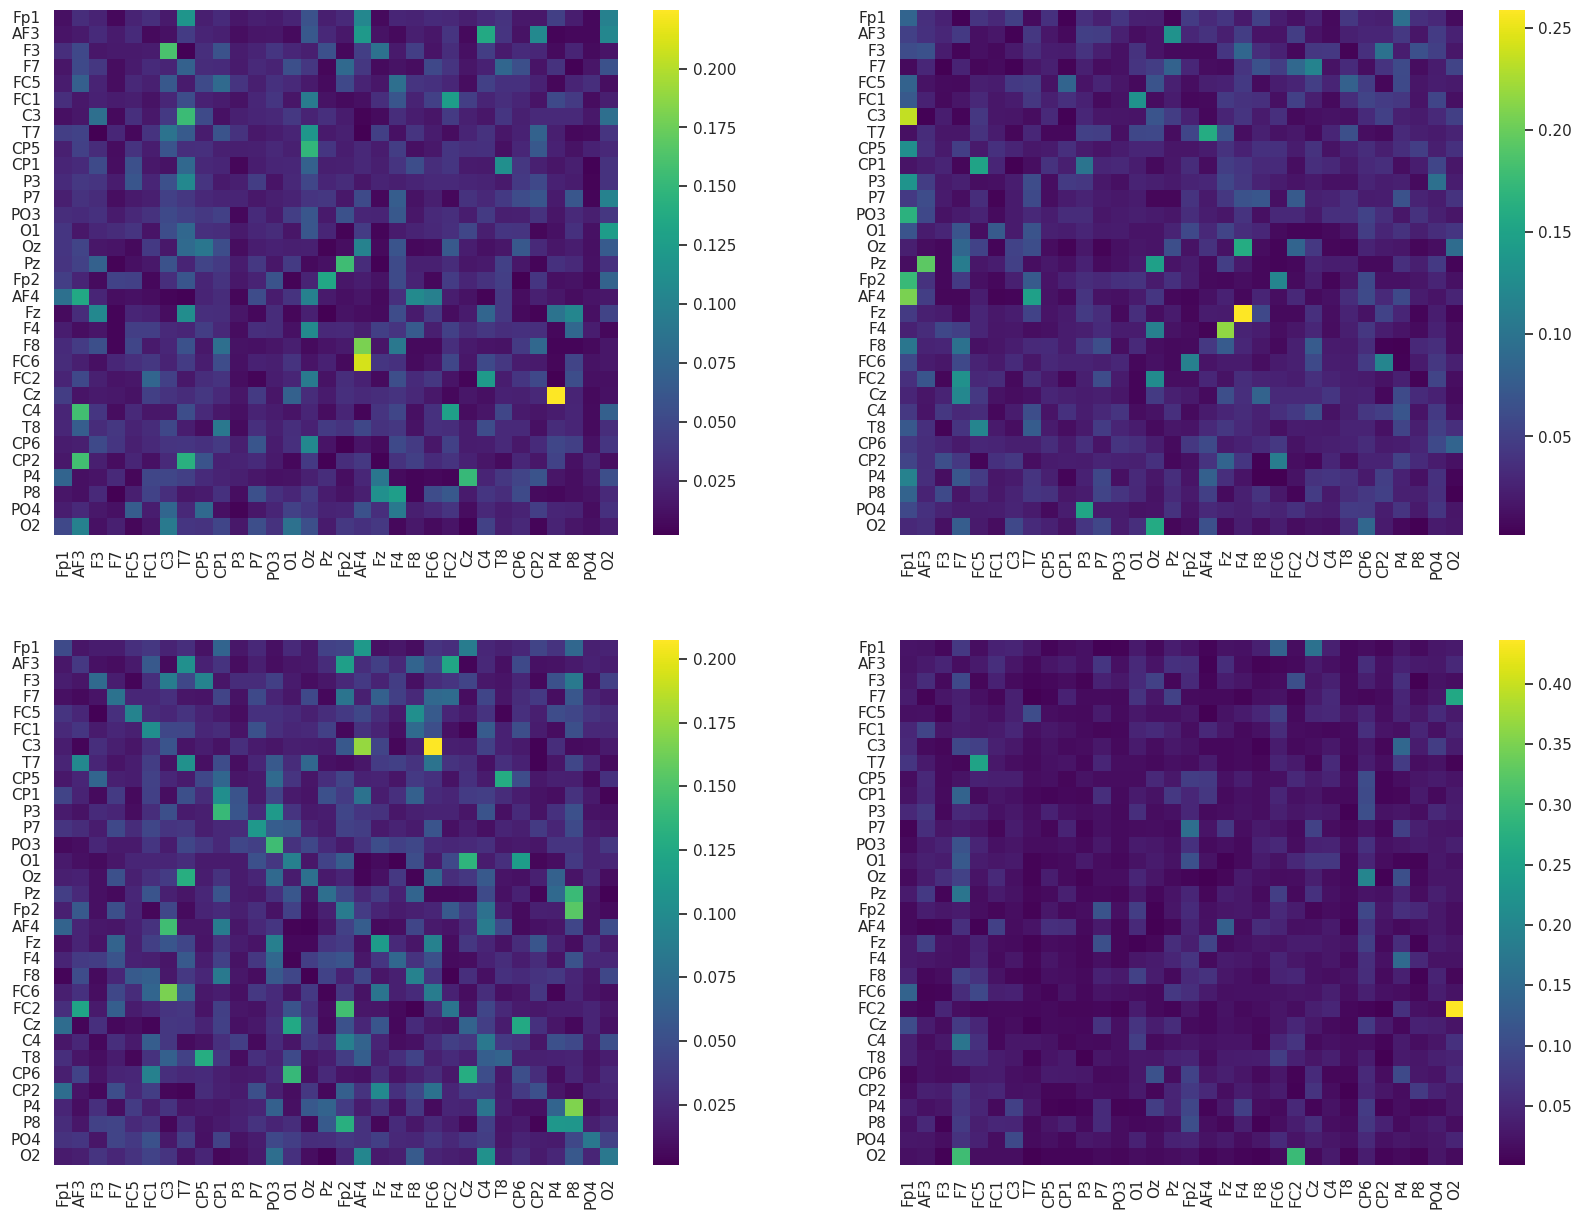

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

attention_heads = attention_grouped[0]

channels = ['Fp1', 'AF3', 'F3', 'F7', 'FC5', 
                         'FC1', 'C3', 'T7', 'CP5', 'CP1', 
                         'P3', 'P7', 'PO3', 'O1', 'Oz', 
                         'Pz', 'Fp2', 'AF4', 'Fz', 'F4', 
                         'F8', 'FC6', 'FC2', 'Cz', 'C4', 
                         'T8', 'CP6', 'CP2', 'P4', 'P8', 
                         'PO4', 'O2']

sns.set(style="whitegrid")
cmap = sns.color_palette("viridis", as_cmap=True)
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
for i in range(attention_heads.shape[0]):
    sns.heatmap(attention_heads[i, :, :].detach().cpu().numpy(), ax=axs[i // 2, i % 2], 
                cmap=cmap,
                xticklabels=channels,
                yticklabels=channels)

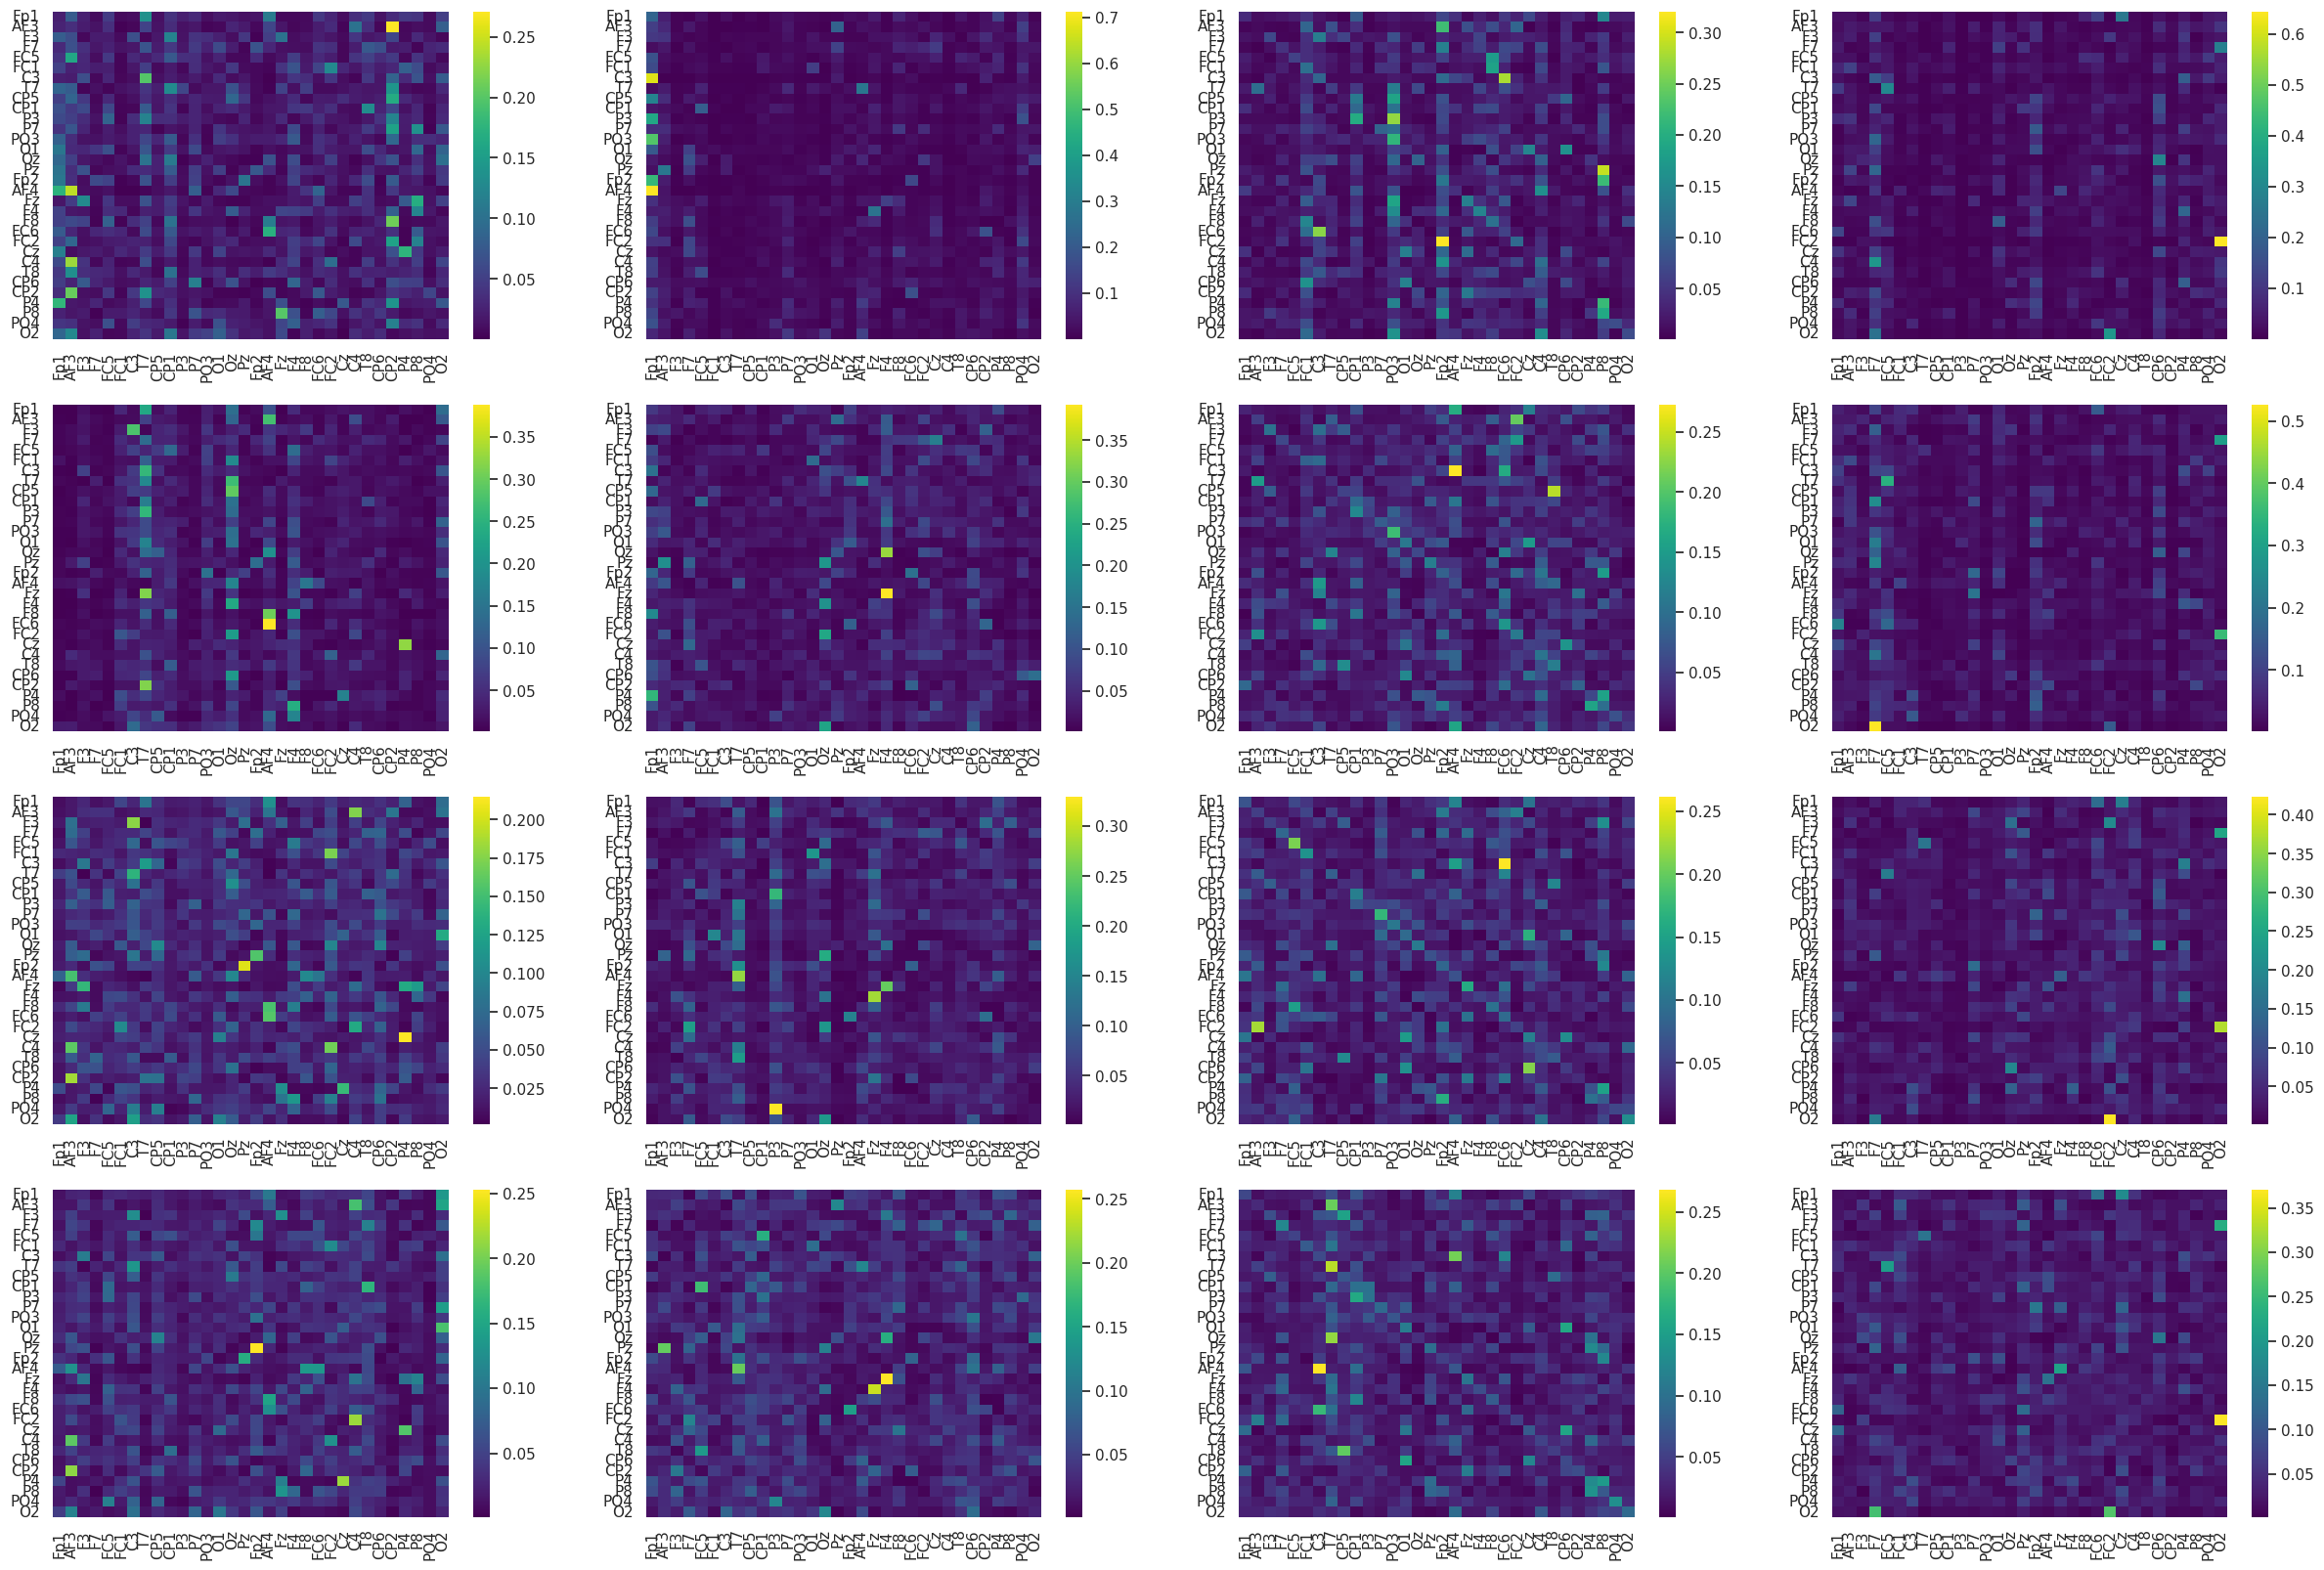

In [89]:
# plot attention for the whole layer

attention_for_all_layers = attention[0]
attention_for_all_layers.shape # (n_layers, n_heads, n_nodes, n_nodes)

channels = ['Fp1', 'AF3', 'F3', 'F7', 'FC5', 
                         'FC1', 'C3', 'T7', 'CP5', 'CP1', 
                         'P3', 'P7', 'PO3', 'O1', 'Oz', 
                         'Pz', 'Fp2', 'AF4', 'Fz', 'F4', 
                         'F8', 'FC6', 'FC2', 'Cz', 'C4', 
                         'T8', 'CP6', 'CP2', 'P4', 'P8', 
                         'PO4', 'O2']

sns.set(style="whitegrid")
cmap = sns.color_palette("viridis", as_cmap=True)
fig, axs = plt.subplots(4, 4, figsize=(30, 20))
for i in range(attention_for_all_layers.shape[0] * attention_for_all_layers.shape[1]):
    sns.heatmap(attention_for_all_layers[i // 4, i % 4, :, :].detach().cpu().numpy(), ax=axs[i // 4, i % 4], # one row == one layer, one column = the same head
                cmap=cmap,
                xticklabels=channels,
                yticklabels=channels)

In [90]:
n_trials = 40
n_bands = 4
n_layers = 4
n_heads = 4
n_nodes = 32

attention_ = attention.view(n_trials, n_bands, n_layers, n_heads, n_nodes, n_nodes)
attention_.shape

torch.Size([40, 4, 4, 4, 32, 32])

In [92]:
import os

for trial in range(n_trials):
    for band in range(n_bands):
        for layer in range(n_layers):
            for head in range(n_heads):
                path = f'0_{trial}_{band}_{layer}_{head}.npy'
                path = os.path.join("../data/attention", path)
                np.save(path, attention_[trial, band, layer, head, :, :].detach().cpu().numpy())

In [94]:
import pandas as pd
import gudhi

def process_connectivity_matrix(mtx, band):
    df = pd.DataFrame(columns=['order', 'birth', 'death', 'band'])
    # mtx is a connectivity matrix, but we need distance matrix
    distance_matrix = 1 - np.abs(mtx[:, :])
    rips_complex = gudhi.RipsComplex(distance_matrix=distance_matrix, max_edge_length=1.0)
    # calculate only zero- and first-order homologies
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    persistence = simplex_tree.persistence()
    for entry in persistence[:-1]: # last entry is (0, inf) for each band for each participant
        order, (birth, death) = entry
        df = pd.concat([df, pd.DataFrame([{'order': order, 'birth': birth, 'death': death, 'band': band}])])
    return df

In [97]:
import warnings
warnings.filterwarnings("ignore")

df = pd.DataFrame()
for trial in range(n_trials):
    for band in range(n_bands):
        for layer in range(n_layers):
            for head in range(n_heads):
                path = f'0_{trial}_{band}_{layer}_{head}.npy'
                path = os.path.join("../data/attention", path)
                mtx = np.load(path)
                current_df = process_connectivity_matrix(mtx, band)
                current_df['trial'] = trial
                current_df['layer'] = layer
                current_df['head'] = head
                df = pd.concat([df, current_df])

# statistics of the barcodes
df.loc[np.isinf(df['death']), 'death'] = 1 # get rid of the infinities
df['bars'] = df['death'] - df['birth']
df['mean_bar'] = df.groupby(['order', 'band'])['bars'].transform('mean')
df['std_bar'] = df.groupby(['order', 'band'])['bars'].transform('std')
df['max_bar'] = df.groupby(['order', 'band'])['bars'].transform('max')
df['min_bar'] = df.groupby(['order', 'band'])['bars'].transform('min')
df['mean_birth'] = df.groupby(['order', 'band'])['birth'].transform('mean')
df['std_birth'] = df.groupby(['order', 'band'])['birth'].transform('std')
df['mean_death'] = df.groupby(['order', 'band'])['death'].transform('mean')
df['std_death'] = df.groupby(['order', 'band'])['death'].transform('std')
df.to_csv('attention.csv', index=False)

In [98]:
df.describe()

,birth,death,trial,layer,head,bars,mean_bar,std_bar,max_bar,min_bar,mean_birth,std_birth,mean_death,std_death
count,179376.000000,179376.000000,179376.000000,179376.000000,179376.000000,179376.000000,179376.000000,179376.000000,179376.000000,179376.000000,179376.000000,179376.000000,179376.000000,179376.000000
mean,0.524266,0.925140,19.451370,1.589416,1.529302,0.400873,0.400873,0.038111,0.513530,0.137450,0.524266,0.010705,0.925140,0.034958
std,0.467223,0.058402,11.533943,1.101555,1.118366,0.431697,0.429298,0.024759,0.433354,0.154914,0.467003,0.009550,0.037810,0.027553
min,0.000000,0.284017,0.000000,0.000000,0.000000,0.000001,0.017508,0.015084,0.121457,0.000001,0.000000,0.000000,0.876940,0.010313
25%,0.000000,0.902607,9.000000,1.000000,1.000000,0.012014,0.017758,0.015322,0.123857,0.000002,0.000000,0.000000,0.885493,0.010348
50%,0.917159,0.948855,19.000000,2.000000,2.000000,0.039553,0.019478,0.017269,0.135703,0.000002,0.939725,0.018442,0.958198,0.010621
75%,0.944493,0.962002,29.000000,3.000000,3.000000,0.887758,0.881353,0.063980,1.000000,0.300098,0.940690,0.019560,0.958832,0.063980
max,0.988230,1.000000,39.000000,3.000000,3.000000,1.000000,0.887422,0.069417,1.000000,0.339063,0.940704,0.020129,0.959412,0.069417


In [101]:
labels_for_participant = pickle.load(open(f"../data/deap_filtered/s01.dat", "rb"), encoding="latin1")["labels"]
for trial in range(n_trials):
    df.loc[(df['trial'] == trial), 'valence'] = labels_for_participant[trial][0]
    df.loc[(df['trial'] == trial), 'arousal'] = labels_for_participant[trial][1]
    df.loc[(df['trial'] == trial), 'dominance'] = labels_for_participant[trial][2]
    df.loc[(df['trial'] == trial), 'liking'] = labels_for_participant[trial][3]

In [106]:
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 434.1 kB/s eta 0:00:00m eta 0:00:010:00:15

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [117]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['trial', 'valence', 'arousal', 'dominance', 'liking'])
X = pd.concat([X, pd.get_dummies(X['band'], prefix='band')], axis=1) # ohe for bands
X = pd.concat([X, pd.get_dummies(X['layer'], prefix='layer')], axis=1) # ohe for layers
X = pd.concat([X, pd.get_dummies(X['head'], prefix='head')], axis=1) # ohe for attention heads
X['order'] = X['order'].astype(np.int64)
X = X.drop(columns=['band', 'layer', 'head'])
y = df['valence']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [118]:
# filter out entries where valence <= 3 or valence >= 7]
indices = (y_train <= 3) | (y_train >= 7)
X_train_filtered = X_train[indices]
y_train_filtered = y_train[indices]
X_test_filtered = X_test[(y_test <= 3) | (y_test >= 7)]
y_test_filtered = y_test[(y_test <= 3) | (y_test >= 7)]

y_train_filtered[y_train_filtered <= 3] = 0
y_train_filtered[y_train_filtered >= 7] = 1
y_test_filtered[y_test_filtered <= 3] = 0
y_test_filtered[y_test_filtered >= 7] = 1

In [119]:
X_train_filtered.dtypes

order           int64
birth         float64
death         float64
bars          float64
mean_bar      float64
std_bar       float64
max_bar       float64
min_bar       float64
mean_birth    float64
std_birth     float64
mean_death    float64
std_death     float64
band_0           bool
band_1           bool
band_2           bool
band_3           bool
layer_0          bool
layer_1          bool
layer_2          bool
layer_3          bool
head_0           bool
head_1           bool
head_2           bool
head_3           bool
dtype: object

In [120]:
# filter warnings
import warnings
warnings.filterwarnings('ignore')

import optuna
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def objective(trial):
    param = {
        'verbosity': 0,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'booster': 'gbtree',
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.4, 0.6, 0.8, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 0.9, 1.0]),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-3, 10.0),
    }
    
    model = XGBClassifier(**param, use_label_encoder=False)
    model.fit(X_train_filtered, y_train_filtered, eval_set=[(X_test_filtered, y_test_filtered)], early_stopping_rounds=10, verbose=False)
    
    # Predict on the validation set
    preds = model.predict(X_test_filtered)
    pred_labels = preds > 0.5
    
    # Evaluate the accuracy of the model
    accuracy = accuracy_score(y_test_filtered, pred_labels)
    
    return accuracy


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

model = XGBClassifier(**study.best_params, use_label_encoder=False)
model.fit(X_train_filtered, y_train_filtered)

# make predictions for test data
y_pred = model.predict(X_test_filtered)

# evaluate predictions
accuracy = accuracy_score(y_test_filtered, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

precision = precision_score(y_test_filtered, y_pred, average='weighted')
print(f"Precision: {precision}")

recall = recall_score(y_test_filtered, y_pred, average='weighted')
print(f"Recall: {recall}")

f1 = f1_score(y_test_filtered, y_pred, average='weighted')
print(f"F1: {f1}")


[I 2024-05-20 03:23:53,162] A new study created in memory with name: no-name-88684d98-f05e-4290-8688-285ca585e432


[I 2024-05-20 03:23:54,076] Trial 0 finished with value: 0.5659790112126412 and parameters: {'lambda': 3.1080150849063752, 'alpha': 0.07175074870134843, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.06491249769808376, 'n_estimators': 755, 'max_depth': 4, 'min_child_weight': 6, 'gamma': 0.002387391485737795}. Best is trial 0 with value: 0.5659790112126412.
[I 2024-05-20 03:23:55,118] Trial 1 finished with value: 0.5659790112126412 and parameters: {'lambda': 0.07614710577132192, 'alpha': 0.001113945962833202, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.052181760547352324, 'n_estimators': 756, 'max_depth': 6, 'min_child_weight': 7, 'gamma': 1.6760137032779818}. Best is trial 0 with value: 0.5659790112126412.
[I 2024-05-20 03:23:56,530] Trial 2 finished with value: 0.5659790112126412 and parameters: {'lambda': 0.04145602186663301, 'alpha': 0.5192995727979152, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.07398389367758758, 'n_estimators': 8

Number of finished trials:  100
Best trial:
  Value:  0.5665775507761063
  Params: 
    lambda: 0.8156019629345508
    alpha: 0.008542540374100965
    colsample_bytree: 0.4
    subsample: 0.8
    learning_rate: 0.29162776734731033
    n_estimators: 991
    max_depth: 8
    min_child_weight: 4
    gamma: 0.0201087229488299
Accuracy: 50.62%
Precision: 0.48970145100507195
Recall: 0.506164957503691
F1: 0.49170001657582874
